In [ ]:
# lr=.05, batch= 128

Parsing config file: Downloads/config1.txt
Loaded 10000 images
torch.Size([2000, 18]) here
torch.Size([2000, 18])
(9, 2)
[59 60 61 53 54 55 56 57 58 59 60 61 62 63 64 65 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64
 65 66 67 68 69 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67
 68 69 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70
 71 72 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 70 71 72 73 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65
 66 67 68 69 70 71 72 73 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62
 63 64 65 66 67 68 69 70 71 72 73 46 47 48 49 50 51 52 53 54 55 56 57 58
 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 46 47 48 49 50
 51

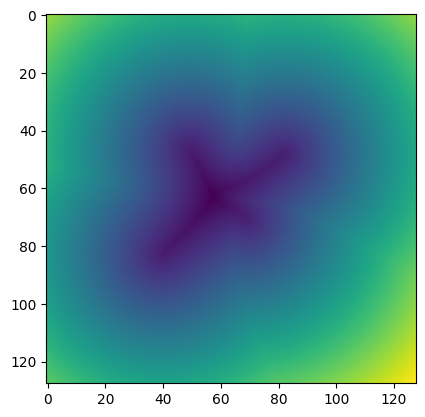

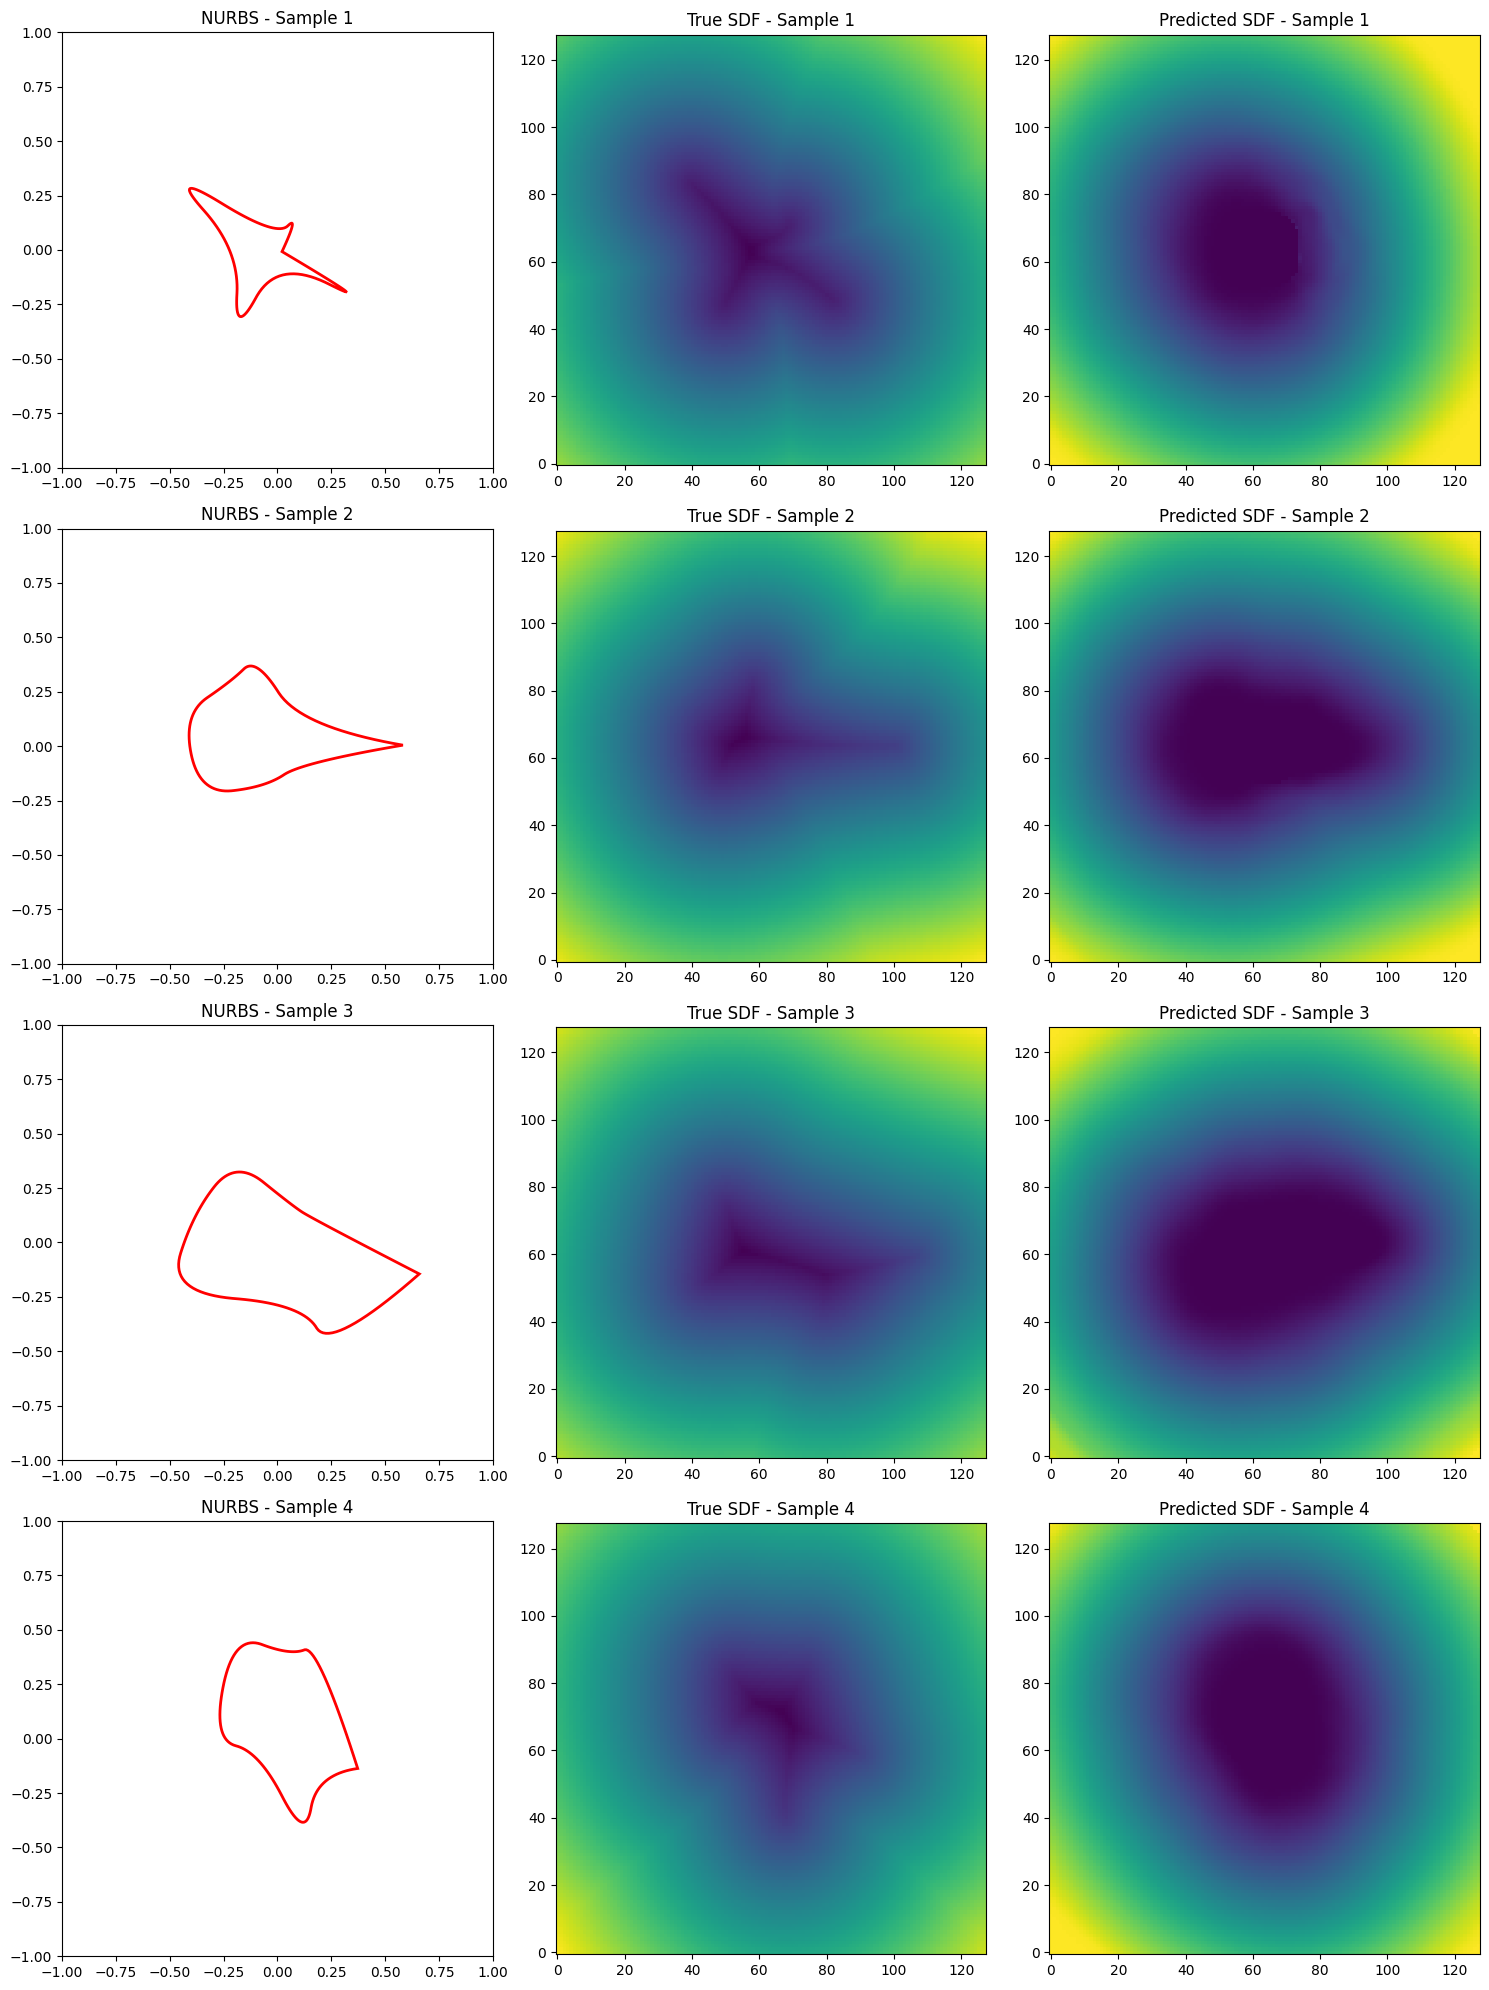

Mean Area Difference: 0.23259747328028246


<Figure size 640x480 with 0 Axes>

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /home/exouser/.local/lib/python3.10/site-packages/lpips/weights/v0.1/alex.pth
Average Loss: 0.0052144731167031244
Average MSE Loss: 0.0052144731167031244
Average LPIPS: 0.0624650574322376
Average PSNR: 23.04203491677349


In [2]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import sys
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Dense, Flatten, Reshape, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from torch.utils.data import DataLoader
from geomdl import NURBS
import time
import pickle
import glob
import re
from collections import OrderedDict
import configparser
import torch
import numpy as np
import lpips
from skimage.metrics import structural_similarity as ssim
import torch.optim as optim

# function to compute signed distance from a point to a convex polygon
def signed_distance_polygon(point, polygon_vertices):
    """
    Calculate the signed distance from a point to a convex polygon.

    Parameters:
    - point: NumPy array of shape (2,) representing the point
    - polygon_vertices: NumPy array of shape (num_vertices, 2) representing the vertices of the convex polygon

    Returns:
    - Signed distance from the point to the polygon
    """
    num_vertices = polygon_vertices.shape[0]

    # Initialize variables
    d = np.inf
    s = 1.0

    for i in range(num_vertices):
        j = (i - 1) % num_vertices
        e = polygon_vertices[j] - polygon_vertices[i]
        w = point - polygon_vertices[i]

        # Calculate the perpendicular distance
        b = w - e * np.clip(np.dot(w, e) / np.dot(e, e), 0.0, 1.0)
        d = min(d, np.linalg.norm(b))

        # Determine the sign based on winding number
        if (polygon_vertices[i, 1] <= point[1] < polygon_vertices[j, 1]) or (polygon_vertices[j, 1] <= point[1] < polygon_vertices[i, 1]):
            if polygon_vertices[i, 1] <= point[1] < polygon_vertices[j, 1]:
                if e[0] * w[1] > e[1] * w[0]:
                    s = -s
            elif polygon_vertices[j, 1] <= point[1] < polygon_vertices[i, 1]:
                if e[0] * w[1] < e[1] * w[0]:
                    s = -s

    return s * d

def curve_point_nurbs(control_pts=[[-0.7, 0.7, 0], [0, 0.7, 0], [0.7, 0.7, 0], [0.7, 0, 0], [0.7, -0.7, 0], [-0.7, 0, 0],[-0.7,-0.7,0],[-0.7,0,0],[-0.7, 0.7, 0]],knotvec= [0, 0,0,0.14285714,0.28571429,0.42857143,0.57142857,0.71428571,0.85714286,1, 1, 1],
                delta=0.007):
    # Create a 3-dimensional B-spline Curve
    curve = NURBS.Curve()

    # Set degree
    curve.degree = 2

    # Set control points (weights vector will be 1 by default)
    # Use curve.ctrlptsw is if you are using homogeneous points as Pw
    # let's vary each point in 1000 * 8
    # 6 CP
    # curve.ctrlpts =[[-0.7, 0.7, 0], [0, 0.7, 0], [0.7, 0.7, 0], [0.7, 0, 0], [0.7, -0.7, 0], [-0.7, 0, 0],[-0.7,-0.7,0],[-0.7,0,0],[-0.7, 0.7, 0]]
    curve.ctrlpts=control_pts
    # 9th control point is same as first control point 
    # let's vary the radius between 0.01 and 0.7 in magnitude and angle theta about -10 to 10 degrees and produce 
    # 60000 samples 
    # Set knot vector
    # this is fixed
    curve.knotvector = knotvec
    # setting this value such that it is not small
    # Set evaluation delta (controls the number of curve points)
    curve.delta = delta

    # Get curve points (the curve will be automatically evaluated)
    return curve.evalpts

class DecoderNetwork(nn.Module):
    def __init__(self, input_shape):
        super(DecoderNetwork, self).__init__()
        input_dim = np.prod(input_shape)  # Compute the total number of input features dynamically

        self.network = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 128 * 128),  # Output is reshaped to 128x128 image
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.network(x)
        x = x.view(-1, 128, 128)  # Reshape output to 128x128 image
        return x

# Helper Functions 
def create_directory(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

def save_model(model, optimizer, loss_per_epoch, epoch, best_val_loss, val_loss_per_epoch, save_path):
    save_dir = create_directory(save_path)
    checkpoint_data = {
        'epoch': epoch,
        'loss_per_epoch': loss_per_epoch,
        'best_val_loss': best_val_loss,
        'val_loss_per_epoch': val_loss_per_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    checkpoint_path = os.path.join(save_dir, "decoder_train_model_epoch.pkl")
    with open(checkpoint_path, 'wb') as checkpoint_file:
        pickle.dump(checkpoint_data, checkpoint_file)

def save_model_epoch(model, epoch, save_path):
    path = create_directory(os.path.join(save_path, "CCmodels_V7"))
    checkpoint_data = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
    }
    checkpoint_path = os.path.join(path, f"model_epoch{epoch}.pkl")
    with open(checkpoint_path, 'wb') as checkpoint_file:
        pickle.dump(checkpoint_data, checkpoint_file)

def load_model_epoch(model, save_path):
    model_files = glob.glob(os.path.join(save_path, "CCmodels_V7/model_epoch*.pkl"))
    latest_model_file = max(model_files, key=lambda x: int(re.findall(r'\d+', x)[-1]))
    with open(latest_model_file, 'rb') as checkpoint_file:
        checkpoint_data = pickle.load(checkpoint_file)
    new_state_dict = OrderedDict()
    for k, v in checkpoint_data['model_state_dict'].items():
        name = k[7:] if k.startswith('module.') else k
        new_state_dict[name] = v
    model.load_state_dict(new_state_dict)
    return model

class CustomDataset(Dataset):
    @staticmethod
    def return_test_train(root_dir, test_size=0.1, random_state=22):
        image_data = []  # Use a local variable to collect images
        files = os.listdir(os.path.join(root_dir, "images2"))
        for i in range(len(files)):
            image = np.load(os.path.join(root_dir, "images2", f"signed_distances{i}.npy"), allow_pickle=True)
            image_data.append(image)

            if len(image_data) == 10000:
                print("Loaded 10000 images")
                break
        # this loads all the control points
        data = np.array(image_data)
        control_points = np.load(os.path.join(root_dir, "lhs_ctrlpts.npy"), allow_pickle=True)
        control_points=control_points[:len(data)]
        train_data_cp, test_data_cp, train_data_sdf, test_data_sdf = train_test_split(
            control_points, data, test_size=test_size, random_state=random_state
        )
        # Convert NumPy arrays to PyTorch tensors
        return (
            torch.tensor(train_data_cp, dtype=torch.float32),
            torch.tensor(test_data_cp, dtype=torch.float32),
            torch.tensor(train_data_sdf, dtype=torch.float32),
            torch.tensor(test_data_sdf, dtype=torch.float32),
        )

    def __init__(self, control_points, signed_distance_functions, perturb_control_points, device='cpu'):
        self.device = device  
        if perturb_control_points:
            self.control_points, self.signed_distance_functions = self.increase_data(
                control_points, signed_distance_functions
            )
        else:
            self.control_points = control_points
            self.signed_distance_functions = signed_distance_functions

    def __len__(self):
        return len(self.control_points)

    def __getitem__(self, idx):
        control_point = self.control_points[idx]
        sdf = self.signed_distance_functions[idx]
        return {"control_point": control_point.to(self.device), "signed_distance_function": sdf.to(self.device)}

    def increase_data(self, control_points, sdf, perturbation_factor=0.001, num_times=5):
        augmented_control_points = control_points.clone()
        augmented_sdf = sdf.clone()
        for _ in range(num_times):
            noise = torch.rand_like(control_points) * 2 * perturbation_factor - perturbation_factor
            perturbed_control_points = control_points + noise
            perturbed_sdf = sdf  
            augmented_control_points = torch.cat((augmented_control_points, perturbed_control_points), dim=0)
            augmented_sdf = torch.cat((augmented_sdf, perturbed_sdf), dim=0)
        return augmented_control_points, augmented_sdf



# function to compute signed distance from a point to a convex polygon
def signed_distance_polygon(point, polygon_vertices):
    """
    Calculate the signed distance from a point to a convex polygon.

    Parameters:
    - point: NumPy array of shape (2,) representing the point
    - polygon_vertices: NumPy array of shape (num_vertices, 2) representing the vertices of the convex polygon

    Returns:
    - Signed distance from the point to the polygon
    """
    num_vertices = polygon_vertices.shape[0]

    # Initialize variables
    d = np.inf
    s = 1.0

    for i in range(num_vertices):
        j = (i - 1) % num_vertices
        e = polygon_vertices[j] - polygon_vertices[i]
        w = point - polygon_vertices[i]

        # Calculate the perpendicular distance
        b = w - e * np.clip(np.dot(w, e) / np.dot(e, e), 0.0, 1.0)
        d = min(d, np.linalg.norm(b))

        # Determine the sign based on winding number
        if (polygon_vertices[i, 1] <= point[1] < polygon_vertices[j, 1]) or (polygon_vertices[j, 1] <= point[1] < polygon_vertices[i, 1]):
            if polygon_vertices[i, 1] <= point[1] < polygon_vertices[j, 1]:
                if e[0] * w[1] > e[1] * w[0]:
                    s = -s
            elif polygon_vertices[j, 1] <= point[1] < polygon_vertices[i, 1]:
                if e[0] * w[1] < e[1] * w[0]:
                    s = -s

    return s * d

def curve_point_nurbs(control_pts=[[-0.7, 0.7, 0], [0, 0.7, 0], [0.7, 0.7, 0], [0.7, 0, 0], [0.7, -0.7, 0], [-0.7, 0, 0],[-0.7,-0.7,0],[-0.7,0,0],[-0.7, 0.7, 0]],knotvec= [0, 0,0,0.14285714,0.28571429,0.42857143,0.57142857,0.71428571,0.85714286,1, 1, 1],
                delta=0.007):
    # Create a 3-dimensional B-spline Curve
    curve = NURBS.Curve()

    # Set degree
    curve.degree = 2

    # Set control points (weights vector will be 1 by default)
    # Use curve.ctrlptsw is if you are using homogeneous points as Pw
    # let's vary each point in 1000 * 8
    # 6 CP
    # curve.ctrlpts =[[-0.7, 0.7, 0], [0, 0.7, 0], [0.7, 0.7, 0], [0.7, 0, 0], [0.7, -0.7, 0], [-0.7, 0, 0],[-0.7,-0.7,0],[-0.7,0,0],[-0.7, 0.7, 0]]
    curve.ctrlpts=control_pts
    # 9th control point is same as first control point 
    # let's vary the radius between 0.01 and 0.7 in magnitude and angle theta about -10 to 10 degrees and produce 
    # 60000 samples 
    # Set knot vector
    # this is fixed
    curve.knotvector = knotvec
    # setting this value such that it is not small
    # Set evaluation delta (controls the number of curve points)
    curve.delta = delta

    # Get curve points (the curve will be automatically evaluated)
    return curve.evalpts

def train(train_loader, model, optimizer, criterion, device, num_epochs, save_path, test_loader):
    model.to(device)
    model.train()

    accumulation_steps = 4  
    # Check if a previous training checkpoint exists
    checkpoint_path = os.path.join(save_path, "train_model_epoch.pkl")
    if os.path.exists(checkpoint_path):
        print("Resuming training from previous checkpoint")
        model, optimizer, start_epoch, loss_per_epoch, best_val_loss, val_loss_per_epoch = load_model(model, optimizer, save_path)
        model.to(device)
        print(f"Starting from epoch {start_epoch + 1}")
    else:
        start_epoch = 0
        loss_per_epoch = []
        val_loss_per_epoch = []
        best_val_loss = float('inf')

    for epoch in range(start_epoch, num_epochs):
        model.train()
        train_loss = 0
        optimizer.zero_grad()

        for batch_idx, batch in enumerate(train_loader):
            control_points = batch['control_point'].to(device)
            signed_distance_functions = batch['signed_distance_function'].to(device)
            output = model(control_points)
            output = output.squeeze(1)
            loss = criterion(output, signed_distance_functions) / accumulation_steps
            loss.backward()
            train_loss += loss.item() * accumulation_steps

            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        train_loss /= len(train_loader.dataset)
        loss_per_epoch.append(train_loss)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for test_batch in test_loader:
                test_cp = test_batch['control_point'].to(device)
                test_sdf = test_batch['signed_distance_function'].to(device)
                test_output = model(test_cp).squeeze(1)
                val_loss += criterion(test_output, test_sdf).item()

        val_loss /= len(test_loader)
        val_loss_per_epoch.append(val_loss)

        print(f"Epoch {epoch + 1}: Train Loss: {train_loss:.10f}, Validation Loss: {val_loss:.10f}")

        if val_loss < best_val_loss and epoch > 2:
            best_val_loss = val_loss
            save_model(model, optimizer, loss_per_epoch, val_loss_per_epoch, epoch, best_val_loss, save_path)

        if (epoch + 1) % 100 == 0:
            save_model_epoch(model, epoch + 1, save_path)
            plt.figure()
            plt.plot(loss_per_epoch, label='Train Loss')
            plt.plot(val_loss_per_epoch, label='Validation Loss')
            plt.title('Loss vs Epochs')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.savefig(os.path.join(save_path, f"CC_V7_loss_plot_epoch_{epoch + 1}.png"))
            plt.close()

    return train_loss


def to_numpy(tensor):
    return tensor.cpu().detach().numpy() if tensor.requires_grad else tensor.cpu().numpy()


def extract_boundary_points(sdf, threshold=0.0125):
    """
    Extract boundary points from the signed distance field.
 
    Args:
        sdf (ndarray): Signed distance field.
        threshold (float): Threshold value to determine the boundary points.
 
    Returns:
        tuple: Arrays of x and y coordinates of the boundary points.
    """
    boundary_points = np.argwhere(np.abs(sdf) < threshold)
    x_coords = boundary_points[:, 1]
    y_coords = boundary_points[:, 0]
    return x_coords, y_coords
def compute_area_inside_bbox_numerical(x_coords, y_coords):
    """
    Compute the area inside the bounding box defined by the boundary points using numerical integration.
 
    Args:
        x_coords (ndarray): Array of x coordinates of the boundary points.
        y_coords (ndarray): Array of y coordinates of the boundary points.
 
    Returns:
        float: Area inside the bounding box.
    """
    if len(x_coords) == 0 or len(y_coords) == 0:
        return 0.0
    min_x, max_x = np.min(x_coords), np.max(x_coords)
    min_y, max_y = np.min(y_coords), np.max(y_coords)
    # Define the grid for numerical integration
    x_grid = np.linspace(min_x, max_x, num=len(x_coords))
    y_grid = np.linspace(min_y, max_y, num=len(y_coords))
    # Compute the area using the trapezoidal rule
    area = np.trapz(y_grid, x=x_grid)
    return area



def calculate_psnr(reference_img, predicted_img):
    mse = np.mean((reference_img - predicted_img) ** 2)
    max_pixel_value = np.max(reference_img)
    psnr = 10 * np.log10((max_pixel_value ** 2) / mse)
    return psnr


def calculate_lpips(reference_img, predicted_img ,loss_fn):
    # If the images have only one channel, duplicate it to get 3 channels
    predicted_img = predicted_img.unsqueeze(1)
    
    if reference_img.shape[1] == 1:
        reference_img = reference_img.repeat(1, 3, 1, 1)
    if predicted_img.shape[1] == 1:
        predicted_img = predicted_img.repeat(1, 3, 1, 1)

    
    return loss_fn(reference_img, predicted_img).mean()

def calculate_ssim(reference_img, predicted_img, device):
    data_range = reference_img.max() - reference_img.min()
    return np.mean(ssim(reference_img[:, 0], predicted_img[:, 0], data_range=data_range, multichannel=False))

def parse_config(config_file):
    print(f'Parsing config file: {config_file}')
    config = configparser.ConfigParser()
    config.read(config_file)
    mode = config.get('Settings', 'mode')
    batch_size = config.getint('Settings', 'batch_size')
    learning_rate = config.getfloat('Settings', 'learning_rate')
    epochs = config.getint('Settings', 'epochs')
    root_directory = config.get('Settings', 'root_directory')
    save_path = config.get('Settings', 'save_path')
    return mode, batch_size, learning_rate, epochs, root_directory, save_path

def print_tensor_details(tensor, name="Tensor"):
    # Print the shape of the tensor
    print(f"{name} shape: {tensor.shape}")
    # Check and print the number of channels if tensor is at least 2D
    if tensor.ndim > 1:
        num_channels = tensor.shape[1]
        print(f"{name} has {num_channels} channels.")
    else:
        print(f"{name} is not a multi-dimensional image tensor.")

def return_test_only(root_dir):
        # return 2000 images and control points after 10000 for testing
        image_data = []  # Use a local variable to collect images
        
        for i in range(10000, 12000):
            image = np.load(os.path.join(root_dir, "images2", f"signed_distances{i}.npy"), allow_pickle=True)
            image_data.append(image)
        control_points = np.load(os.path.join(root_dir, "lhs_ctrlpts.npy"), allow_pickle=True)
        control_points=control_points[10000:12000]
        # Convert NumPy arrays to PyTorch tensors
        image_data = np.array(image_data)
        
        return (
            torch.tensor(control_points, dtype=torch.float32),
            torch.tensor(image_data, dtype=torch.float32),
        )

def test_func(test_data_cp, test_data_sdf, test_loader, save_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_shape = test_data_cp[0].shape
    model = DecoderNetwork(input_shape).to(device)
    model = load_model_epoch(model, save_path)
    model.eval()
    print(test_data_cp.shape)
    

    selected_indices = [0, 1, 2, 3]
    test_data_cp = test_data_cp.to(device)
    selected_test_data_cp = test_data_cp[selected_indices]
    selected_test_data_sdf = test_data_sdf[selected_indices]

    area_diff = []

    computed_sdf = model(selected_test_data_cp)
    computed_sdf_np = to_numpy(computed_sdf)
    fig, axs = plt.subplots(len(selected_indices), 3, figsize=(15, 5 * len(selected_indices)))

    for i in range(len(selected_indices)):
        axs[i,0].set_xlim(-1, 1)
        axs[i,0].set_ylim(-1, 1)
       
        x_data_i = to_numpy(selected_test_data_cp[i]).reshape(-1, 2)  # Reshape for NURBS
        print(x_data_i.shape)
        y_data_i_true = to_numpy(selected_test_data_sdf[i])
        y_data_i_pred = computed_sdf_np[i]

        polygon = curve_point_nurbs(x_data_i)
        #print(polygon)
        axs[i, 0].add_patch(Polygon(polygon, edgecolor='red', fill=None, linewidth=2))
        axs[i, 0].set_title(f'NURBS - Sample {i + 1}')
        img_true = axs[i, 1].imshow(y_data_i_true,origin='lower')
        axs[i, 1].set_title(f'True SDF - Sample {i + 1}')
        img_pred = axs[i, 2].imshow(y_data_i_pred, origin='lower')
        axs[i, 2].set_title(f'Predicted SDF - Sample {i + 1}')

        x_coords, y_coords = extract_boundary_points(y_data_i_true)
        # compute the area inside the bounding box
        
        area_true = compute_area_inside_bbox_numerical(x_coords, y_coords)
        x_coords, y_coords = extract_boundary_points(y_data_i_pred)
        print(x_coords,'hi',y_coords)
        # compute the area inside the bounding box
        area_pred = compute_area_inside_bbox_numerical(x_coords, y_coords)
        # add the area difference and append to the list
        area_diff.append(np.abs(area_true - area_pred)/area_true)
        #area_diff.append(np.abs(area_true - area_pred)/area_true)

    # Print the area information
        print(f'Sample {selected_indices[i]}: True Area = {area_true}, Predicted Area = {area_pred}')

        
    
    
    
    plt.tight_layout()
    plt.savefig('CC_test_V7_visualization.png')
    plt.show()

    
    
     # Show the plot
    mean_area_diff = np.mean(area_diff)
    print(f'Mean Area Difference: {mean_area_diff}')
    plt.tight_layout()
    plt.savefig('CCpkp7.png')
    plt.show()
    
    
    
    loss_fn_MSE = torch.nn.MSELoss().to(device) 
    losses = []
    lpips_vals = []
    psnr_vals = []
    # ssim_vals = []
    loss_fn_LP = lpips.LPIPS(net='alex')
    loss_fn_LP = loss_fn_LP.to(device)
    

    for batch_idx, batch in enumerate(test_loader):
        control_point = batch['control_point'].to(device)
        signed_distance_function = batch['signed_distance_function'].to(device)

        with torch.no_grad():
            computed_sdf = model(control_point)
            loss_val = loss_fn_MSE(computed_sdf, signed_distance_function)
            losses.append(loss_val.item())
            computed_sdf = computed_sdf.unsqueeze(1)
            signed_distance_function = signed_distance_function.unsqueeze(1)
            # Ensuring the tensor has three channels for LPIPS
            if signed_distance_function.shape[1] == 1:
                signed_distance_function = signed_distance_function.repeat(1, 3, 1, 1)
            
            if computed_sdf.shape[1]==1:
                computed_sdf = computed_sdf.repeat(1, 3, 1, 1)
                
                

            # print(f"Computed SDF Shape: {computed_sdf.shape}")  # Debugging statement
            # print(f"Signed Distance Function Shape: {signed_distance_function.shape}")  # Debugging statement

            lpips_val = loss_fn_LP(computed_sdf, signed_distance_function).mean()
            lpips_vals.append(lpips_val.item())

            # Convert to numpy for PSNR calculations
            np_computed_sdf = to_numpy(computed_sdf)
            np_signed_distance_function = to_numpy(signed_distance_function)
            psnr_val = calculate_psnr(np_computed_sdf, np_signed_distance_function)
            psnr_vals.append(psnr_val)
    print(f"Average Loss: {sum(losses) / len(losses)}")
    print(f"Average MSE Loss: {np.mean(losses)}")
    print(f"Average LPIPS: {np.mean(lpips_vals)}")
    print(f"Average PSNR: {np.mean(psnr_vals)}")
    

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

def main():
    config_file_path = 'Downloads/config1.txt'
    mode, batch_size, learning_rate, epochs, root_directory, save_path = parse_config(config_file_path)

    test_data_cp, _, test_data_sdf, _ = CustomDataset.return_test_train(root_directory)
    test_data_cp = test_data_cp.view(test_data_cp.size(0), -1)  # Flatten control points 

    # Data Loading
    train_dataset = CustomDataset(test_data_cp, test_data_sdf, perturb_control_points=False)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    small_batch_size = 2

    test_data_cp_1,test_data_sdf_1= return_test_only(root_directory)
    test_data_cp_1 = test_data_cp_1.view(test_data_cp.size(0), -1)  # Flatten control points 
    
    test_loader = DataLoader(train_dataset, batch_size=small_batch_size, shuffle=False)  
    # Model setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

   #test
    input_features = test_data_cp.shape[1]  
    model = DecoderNetwork(input_features).to(device)


    test_data_cp_1 = test_data_cp_1.view(-1, input_features)  
    
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    
    if mode == 'train':
        train(train_loader, model, optimizer, criterion, device, epochs, save_path, test_loader)
    elif mode == 'test':
        print(test_data_cp_1.shape , 'here')
        plt.imshow(test_data_sdf_1[0].reshape(128,128))

        test_func(test_data_cp_1, test_data_sdf_1, test_loader, save_path)

if __name__ == '__main__':
    main()


